# Project 6 - 뉴스기사 요약해보기

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

('news_summary_more.csv', <http.client.HTTPMessage at 0x7fdeec760310>)

다운받은 뉴스 기사 데이터를 data 폴더에 옮겨준다.

### (1) 데이터 수집하기

In [2]:
data = pd.read_csv('./data/news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

headlines  \
63235  US to classify data on Afghan forces' casualti...   
23953  I'm Muslim and I wear bikini, it doesn't make ...   
56159  No evidence against Indians over alleged Ashes...   
95618  Baseball players lie down on the field as bees...   
82828  India, China deploy 3,000 troops in Sikkim ami...   
91868  A man once established a country in internatio...   
70048  B'luru cops deny permission for 'Bol Aunty Aun...   
70169  2200 primary schools in Odisha have only one c...   
91066  Eid release of Salman's Tubelight being oppose...   
16911       85-year-old foils robbery attempt in Ireland   

                                                    text  
63235  The US' Special Inspector General for Afghanis...  
23953  Speaking about being trolled for posting pictu...  
56159  The BCCI's Anti-Corruption and Security Unit c...  
95618  A swarm of bees overtook a baseball field, sen...  
82828  Both India and China have deployed around 3,00...  
91868  Major Roy Bates, who served the British Army d...  
70048  The Bengaluru Police has denied granting permi...  
70169  At least 2,205 primary schools in Odisha have ...  
91066  The release of Salman Khan's upcoming film Tub...  
16911  Denis O'Connor, an 85-year-old man foiled a ro...

### (2) 데이터 전처리

In [4]:
print("Total sample num :", len(data))

Total sample num : 98401


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.dropna(axis=0, inplace=True)
print('Total unique sample num :', len(data))

Total unique sample num : 98360


정규화 사전, 불용어, 정규표현식을 이용하여 data preprocessing을 수행한다.

In [6]:
# text normalization
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
print("contractions num :", len(contractions))

contractions num : 120


In [9]:
print(stopwords.words('english'))
print('stopwords num :', len(stopwords.words('english') ))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경
    
    if remove_stopwords: # 불용어 제거 (text)
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else: # 불용어 미제거 (headlines)
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
        
    return tokens

In [12]:
# 전체 text 데이터에 대한 전처리
clean_text = []
n = 1

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))
    
    if n % 1000 == 0:
        print(f"{n} / {len(data['text'])}")
        
    n += 1

print("text 전처리 결과 :", clean_text[:5])

1000 / 98360
2000 / 98360
3000 / 98360
4000 / 98360
5000 / 98360
6000 / 98360
7000 / 98360
8000 / 98360
9000 / 98360
10000 / 98360
11000 / 98360
12000 / 98360
13000 / 98360
14000 / 98360
15000 / 98360
16000 / 98360
17000 / 98360
18000 / 98360
19000 / 98360
20000 / 98360
21000 / 98360
22000 / 98360
23000 / 98360
24000 / 98360
25000 / 98360
26000 / 98360
27000 / 98360
28000 / 98360
29000 / 98360
30000 / 98360
31000 / 98360
32000 / 98360
33000 / 98360
34000 / 98360
35000 / 98360
36000 / 98360
37000 / 98360
38000 / 98360
39000 / 98360
40000 / 98360
41000 / 98360
42000 / 98360
43000 / 98360
44000 / 98360
45000 / 98360
46000 / 98360
47000 / 98360
48000 / 98360
49000 / 98360
50000 / 98360
51000 / 98360
52000 / 98360
53000 / 98360
54000 / 98360
55000 / 98360
56000 / 98360
57000 / 98360
58000 / 98360
59000 / 98360
60000 / 98360
61000 / 98360
62000 / 98360
63000 / 98360
64000 / 98360
65000 / 98360
66000 / 98360
67000 / 98360
68000 / 98360
69000 / 98360
70000 / 98360
71000 / 98360
72000 / 98360
7

In [13]:
# 전체 headlines 데이터에 대한 전처리
clean_headlines = []
n = 1

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, False))
    
    if n % 10000 == 0:
        print(f"{n} / {len(data['headlines'])}")
        
    n += 1

print("headlines 전처리 후 결과 :", clean_headlines[:5])

10000 / 98360
20000 / 98360
30000 / 98360
40000 / 98360
50000 / 98360
60000 / 98360
70000 / 98360
80000 / 98360
90000 / 98360
headlines 전처리 후 결과 : ['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more', 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under

전처리 과정은 시간이 오래 걸리므로 새로운 데이터프레임에 저장해놓는다.

In [29]:
data = pd.DataFrame()

data['headlines'] = clean_headlines
data['text'] = clean_text

In [30]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [31]:
print('Total clean data num :', (len(data)))

Total clean data num : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 69
요약의 평균 길이 : 56.180195201301345


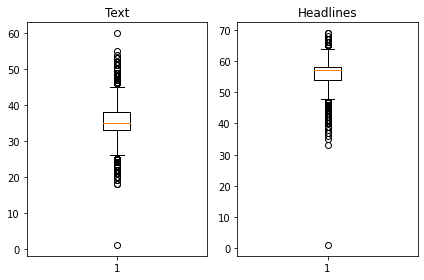

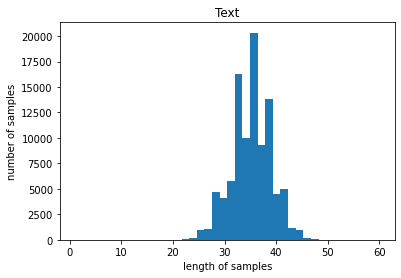

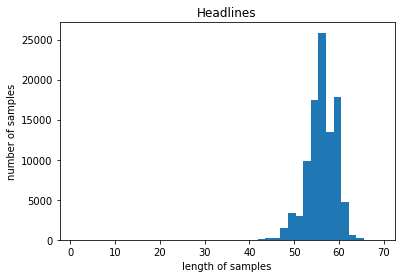

In [32]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
text_max_len = 40
headlines_max_len = 60

In [34]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [35]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9443777958519723


### (3) input, output 데이터 나누기

In [37]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 86632


In [38]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

headlines  \
0  saurav kant an alumnus of upgrad and iiit pg p...   
2  new zealand defeated india by wickets in the f...   
3  with aegon life iterm insurance plan customers...   
4  speaking about the sexual harassment allegatio...   
5  pakistani singer rahat fateh ali khan has deni...   

                                                text  \
0  saurav kant alumnus upgrad iiit pg program mac...   
2  new zealand defeated india wickets fourth odi ...   
3  aegon life iterm insurance plan customers enjo...   
4  speaking sexual harassment allegations rajkuma...   
5  pakistani singer rahat fateh ali khan denied r...   

                                       decoder_input  \
0  sostoken saurav kant an alumnus of upgrad and ...   
2  sostoken new zealand defeated india by wickets...   
3  sostoken with aegon life iterm insurance plan ...   
4  sostoken speaking about the sexual harassment ...   
5  sostoken pakistani singer rahat fateh ali khan...   

                                      decoder_target  
0  saurav kant an alumnus of upgrad and iiit pg p...  
2  new zealand defeated india by wickets in the f...  
3  with aegon life iterm insurance plan customers...  
4  speaking about the sexual harassment allegatio...  
5  pakistani singer rahat fateh ali khan has deni...

In [39]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [40]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[40430  2612  7994 ... 18147 19088 50998]


In [41]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [42]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17326


In [43]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 69306
훈련 레이블의 개수 : 69306
테스트 데이터의 개수 : 17326
테스트 레이블의 개수 : 17326


### (4) 정수 인코딩

__source tokenizing__

In [44]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [45]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64806
등장 빈도가 6번 이하인 희귀 단어의 수: 44300
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20506
단어 집합에서 희귀 단어의 비율: 68.35786809863285
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7903023814729466


In [46]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [47]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[11172, 11886, 376, 1018, 3386, 3410, 4843, 436, 318, 637, 1260, 3410, 17976, 234, 400, 1122, 3411, 5078, 377, 1045, 1157, 5078, 53, 13130, 1, 11172, 3410, 6, 3913, 74, 4634, 6865, 436], [3939, 1962, 107, 2310, 5199, 2528, 137, 1409, 3714, 2283, 326, 6009, 4044, 1379, 540, 952, 19100, 4044, 2897, 294, 691, 331, 1449, 328, 209, 1409, 482, 4044, 538, 471, 4132, 12681, 2012, 552, 98], [3327, 35, 49, 215, 136, 37, 16, 1021, 251, 59, 1, 462, 1037, 136, 56, 300, 190, 1190, 1205, 13131, 955, 6163, 37, 35, 4, 68, 35, 359, 483, 84, 6295, 2627, 136, 116, 1158, 36]]


__target tokenizing__

In [48]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [50]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64949
등장 빈도가 6번 이하인 희귀 단어의 수: 44306
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20643
단어 집합에서 희귀 단어의 비율: 68.21660071748603
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.3023480847089086


In [51]:
tar_vocab = 20000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [52]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[12, 11302, 12017, 7, 476, 1127, 3507, 3531, 8, 4965, 35, 3, 18, 538, 48, 418, 744, 1371, 3531, 18114, 329, 4, 120, 500, 10, 15, 11, 28, 1231, 86, 3532, 5200, 3, 226, 477, 1154, 21, 1267, 10, 15, 11, 28, 5200, 17, 106, 118, 14, 13262, 9, 11302, 3531, 29, 44, 4034, 144, 4755, 6989, 3, 18, 538], [12, 4060, 3, 25, 2078, 2, 183, 2428, 7, 5321, 2647, 2, 28, 222, 1522, 5, 3835, 2401, 52, 40, 426, 6133, 4165, 1, 1492, 643, 1061, 1, 19238, 10, 4165, 11, 25, 3016, 86, 391, 4, 166, 798, 431, 86, 1562, 2, 428, 302, 1522, 585, 4165, 7, 31, 641, 573, 4253, 3, 12812, 2128, 3, 655, 171], [12, 3448, 94, 110, 309, 221, 96, 60, 1130, 347, 6, 125, 9, 3, 564, 1146, 221, 122, 398, 281, 3, 18, 1300, 1315, 188, 13263, 1064, 15, 14, 6287, 8, 1, 96, 86, 1, 94, 15, 36, 15, 64, 135, 94, 2, 459, 25, 586, 4, 224, 155, 6419, 4, 2746, 221, 196, 176, 67, 53, 1268, 1, 95], [12, 876, 10, 7, 97, 405, 7, 995, 3, 1508, 1, 2836, 550, 8032, 10997, 1098, 5, 112, 14, 1611, 1788, 190, 845, 42, 9569, 2, 667, 1, 25

In [53]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 69306
훈련 레이블의 개수 : 69306
테스트 데이터의 개수 : 17326
테스트 레이블의 개수 : 17326


In [56]:
# Padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### (5) 모델 설계하기

__LSTM 3층으로 Encoder를 설계한다.__

In [57]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸림
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

__LSTM 1층으로 Decoder를 설계한다.__

In [ ]:
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)(decoder_inputs)
dec_emb = dec_emb_layer

In [58]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb = Embedding(tar_vocab, embedding_dim)(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [59]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

__최종 모델의 형태는 다음과 같다.__

In [60]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### (6) 어텐션 메커니즘 적용

In [61]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### (7) 모델 훈련하기

__Early Stopping__
> val_loss을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 n회(patience) 관측되면 학습을 멈추는 방식  
> EarlyStopping이 작동하면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있다.  

> 단, patience가 0이 아닌 경우에는 훈련이 종료되었을 때 성능이 최고인 상황이 아닐 수 있다.  
> 그래서 보통 학습 중에 모델을 저장하는 callback 함수를 같이 사용한다.

In [62]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
271/271 [==============================] - 138s 480ms/step - loss: 6.4124 - val_loss: 5.8463
Epoch 2/50
271/271 [==============================] - 131s 485ms/step - loss: 5.5215 - val_loss: 5.2008
Epoch 3/50
271/271 [==============================] - 131s 485ms/step - loss: 5.0524 - val_loss: 4.8933
Epoch 4/50
271/271 [==============================] - 132s 486ms/step - loss: 4.7562 - val_loss: 4.6369
Epoch 5/50
271/271 [==============================] - 131s 485ms/step - loss: 4.5146 - val_loss: 4.4289
Epoch 6/50
271/271 [==============================] - 132s 486ms/step - loss: 4.2957 - val_loss: 4.2105
Epoch 7/50
271/271 [==============================] - 131s 485ms/step - loss: 4.0729 - val_loss: 3.9814
Epoch 8/50
271/271 [==============================] - 131s 485ms/step - loss: 3.8381 - val_loss: 3.7152
Epoch 9/50
271/271 [==============================] - 132s 487ms/step - loss: 3.5968 - val_loss: 3.4353
Epoch 10/50
271/271 [==============================] - 132s 486m

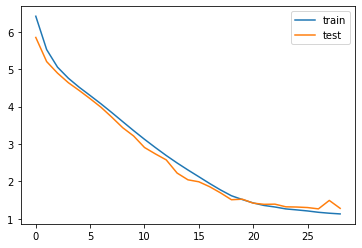

In [63]:
# 데이터 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### (8) 인퍼런스 모델 구현

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

In [64]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [66]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [67]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [68]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token != 'eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### (9) 모델 테스트 - 실제 결과와 요약문 비교

In [69]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if((i != 0 and i != tar_word_to_index['sostoken']) and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp 

In [71]:
for i in range(50, 80):
    print("Original:", seq2text(encoder_input_test[i]))
    print("Summary:", seq2headlines(decoder_input_test[i]))
    print("Abstract:", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

Original: eighty two year old tokyo japan works dj clubs night day works chinese restaurant owned spent year undergoing dj training local music school got energy goes beyond age equal young person said year old 
Summary: eighty two year old from tokyo japan works as dj in clubs at night during the day she works at chinese restaurant that is owned by her she spent year undergoing dj training in local music school she is got this energy that goes beyond age and that can equal any young person here said year old 
Abstract:  two eighty year old tokyo japan works dj clubs night day works at chinese restaurant owned by the year after undergoing dj training local music school got the energy to goes beyond the age of equal young person said the year old was the year old


Original: wwe champion jinder mahal received customised jersey ipl champions mumbai indians hello india wwe champion jinder mahal cannot thank mumbai indian enough custom jersey name take pride wearing jersey mahal said recei

Abstract:  residents of vadodara th were the cleanest city in the country on sunday created guinness world record number of people sweeping floor single venue of people in world record attempt witnessed around people event tribute to prime minister narendra modi swachh bharat abhiyan


Original: hackers stole crore pune bank august august cloned visa rupay debit cards hacking bank switch server fake switch server approved transactions worth crore countries august august nearly crore transferred hong kong swift transaction 
Summary: the hackers who stole crore from pune bank between august and august cloned visa and rupay debit cards by hacking the bank switch server the fake switch server approved transactions worth over crore in countries on august on august nearly crore was transferred to hong kong through swift transaction 
Abstract:  hackers stole crore pune bank in august on august after it was cloned visa and digital debit cards hacking bank switch server fake switch server appro

Abstract:  pakistani pacer hasan ali trolled sri lankan batsman after he was pretending to take catch with the ball on the ground on thursday edged delivery to know the ball ali went near the catch next delivery ali caught bowled out dismissing him and then dismissing him


Original: west bengal bjp accused trinamool congress murdering democracy snatched away democratic rights tmc confident development done allow masses vote freely questioned widespread violence panchayat polls monday left least people dead injured 
Summary: the west bengal bjp has accused the trinamool congress of murdering democracy they have snatched away the democratic rights if the tmc is so confident of the development it has done then why did not it allow the masses to vote freely it questioned widespread violence during the panchayat polls on monday left at least people dead and over injured 
Abstract:  west bengal bjp accused trinamool congress of murdering democracy and snatched away democratic rights tmc has

Abstract:  talking about his upcoming film india cricket world cup victory ranveer singh plays former indian cricketer kapil dev actor said hope kapil sir gives training tips ranveer added he hopes gets dev bowling action correct titled film is scheduled to release on april


Original: team india accused australia leaking stories dressing room conversations media hosts reportedly looking take matter authorities per reports australian team manager introduced australian journalist match referee chris broad icc protocol india also accused australian media manager planting stories 
Summary: team india has accused australia of leaking stories and dressing room conversations to the media with the hosts reportedly looking to take up the matter with authorities as per reports australian team manager introduced an australian journalist to match referee chris broad which is against icc protocol india has also accused the australian media manager of planting stories 
Abstract:  team india accused

### (10) 추출적 요약 - Summa 이용

In [72]:
import requests
from summa.summarizer import summarize

In [83]:
text = data['text'][50]
print(text)

former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said comes media report tuesday accused dhfl controlling shareholders diverting funds shell companies buy assets


In [82]:
text = data['text'][]
print(type(text))
print('Summary:')
print(summarize(text, ratio=0.5))

<class 'str'>
Summary:



In [79]:
print(type(text))
print('Summary:')
print(summarize(text, words=50))

<class 'str'>
Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [74]:
abstract = []
extract = []

for i in range(50, 80):
    a = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    e = summarize(seq2text(encoder_input_test[i]), ratio=0.1)
    print("Abstract:", a)
    print("Extract:", e)
    print("\n")
    abstract.append(a)
    extract.append(e)

Abstract:  two eighty year old tokyo japan works dj clubs night day works at chinese restaurant owned by the year after undergoing dj training local music school got the energy to goes beyond the age of equal young person said the year old was the year old
Extract: 


Abstract:  wwe champion jinder mahal received customised jersey for ipl champions mumbai indians to hello india wwe champion alongside the mahal cannot thank mumbai for the indian enough custom jersey name will take pride wearing jersey mahal said receiving jersey
Extract: 




KeyboardInterrupt: 

- 문법 완성도

- 핵심 단어 포함